In [1]:
!pip install keras
!pip install tensorflow-gpu==2.2
!sudo -H pip install pydot
!sudo -H pip install graphviz
!sudo -H pip install pydotplus

In [15]:
!sudo -H apt update -y
!sudo -H apt install libgl1-mesa-glx -y

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [98.3 kB]     
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [107 kB]      
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [840 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [784 kB]
Fetched 1,941 kB in 1s (2,340 kB/s)                      
Reading package lists... Done
Building dependency tree       
Reading state information... Done
1 package can be upgraded. Run 'apt list --upgradable' to see it.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [2]:
# !conda install pydot
# !conda install pydotplus
# !conda install -c anaconda graphviz


In [13]:
!pip install opencv-python

In [1]:
import sys
import numpy as np
import pandas as pd
# from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

# import cv2
import time
from keras.optimizers import SGD

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.models import load_model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Cropping2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D

from sklearn import metrics


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
# #################################
    input_shape=(400, 225, 3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Initialising the CNN    
    # Convolutional Neural Network
    model = Sequential()

    # Step 1 - Convolution
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    # Adding a second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    # Adding a third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    # Adding a fourth convolutional layer
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())

    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
#     keras.utils.plot_model(siamese_net, "multi_input_and_output_model.png", show_shapes=True)
    # return the model
    return siamese_net

In [4]:
model = get_siamese_model((400, 225, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 225, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 400, 225, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          423232      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           sequential[1][0]             

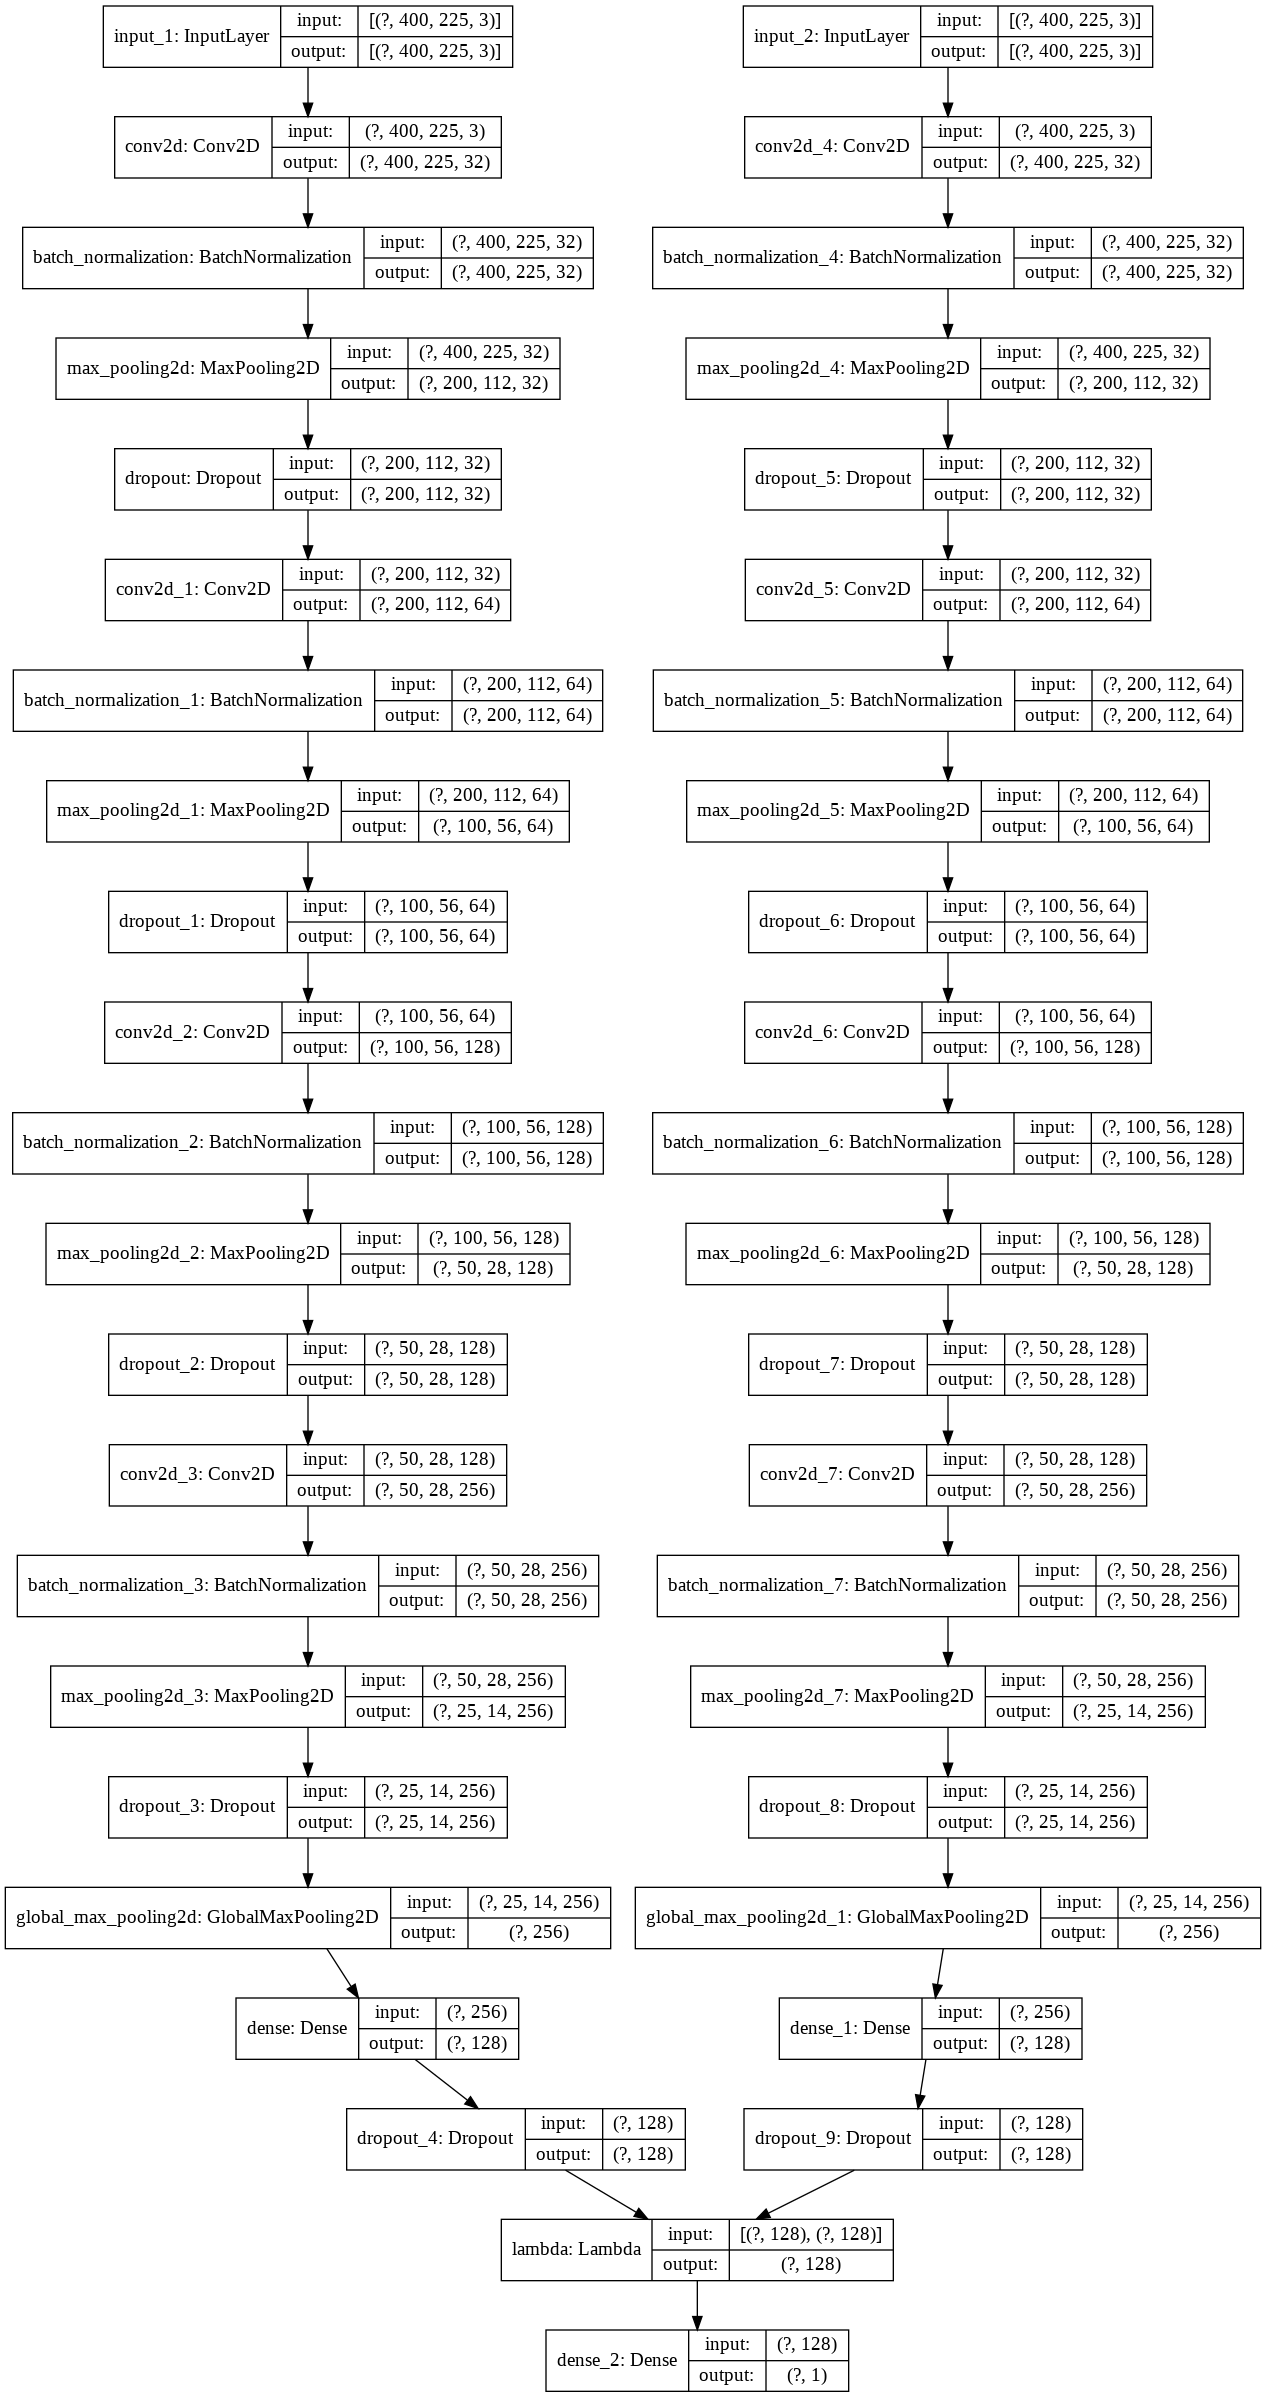

In [5]:
from IPython.display import Image
Image(retina=True, filename='multi_input_and_output_model.png')

In [6]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics =[tf.keras.metrics.AUC()])

In [7]:
model.load_weights("weights_imported/siamese_4layers_day1_v1-epoch34.h5")

In [8]:
# Part 2 - Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   vertical_flip = True,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(                                 )

training_set = train_datagen.flow_from_directory('data/Florida/day1_full/train/',
                                                 target_size = (400, 225),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('data/Florida/test_3096/',
                                            target_size = (400, 225),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

# test_set = test_datagen.flow_from_directory('data/Florida/day1_full/test/',
#                                             target_size = (400, 225),
#                                             batch_size = batch_size,
#                                             class_mode = 'binary')

Found 32410 images belonging to 2 classes.
Found 3097 images belonging to 2 classes.


In [10]:


batch_size=32
img_height = 225
img_width = 400
dir1= 'data/Florida/day1_full/train/'
# dir2= 'data/Florida/day1_full/test/'
dir2= 'data/Florida/test_3096/'


input_imgen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   rotation_range=5.,
                                   horizontal_flip = True)

test_imgen = ImageDataGenerator(rescale = 1./255)


def generate_generator_multiple(generator,dir1, dir2, batch_size, img_height,img_width):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (img_height,img_width),
                                          class_mode = 'binary',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_directory(dir2,
                                          target_size = (img_height,img_width),
                                          class_mode = 'binary',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            
            
inputgenerator=generate_generator_multiple(generator=input_imgen,
                                           dir1=dir1,
                                           dir2=dir1,
                                           batch_size=batch_size,
                                           img_height=img_height,
                                           img_width=img_width)       
     
testgenerator=generate_generator_multiple(test_imgen,
                                          dir1=dir2,
                                          dir2=dir2,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_width)              
steps_per_epoch =round(len(training_set))
validation_steps =round(len(test_set))
print(steps_per_epoch)
print(validation_steps)

history=model.fit(inputgenerator,
                        steps_per_epoch=steps_per_epoch,
                        epochs = 2,
                        validation_data = testgenerator,
                        validation_steps = validation_steps,
#                         use_multiprocessing=True,
                        shuffle=False)



1013
97
Found 32410 images belonging to 2 classes.
Found 32410 images belonging to 2 classes.
Epoch 1/2
1013/1013 [==============================] - ETA: 0s - loss: 0.0657 - auc: 0.9981 Found 3097 images belonging to 2 classes.
Found 3097 images belonging to 2 classes.
1013/1013 [==============================] - 12936s 13s/step - loss: 0.0657 - auc: 0.9981 - val_loss: 0.8754 - val_auc: 0.5000
Epoch 2/2
1013/1013 [==============================] - 12956s 13s/step - loss: 0.1963 - auc: 0.9769 - val_loss: 0.8367 - val_auc: 0.5000


In [11]:
# #load weights
# model = load_model("weights_imported/siamese_4layers_day1_v1-epoch1.h5")
#model= model.load_weights("weights_imported/siamese_4layers_day1_v1-epoch34.h5")
# model.load_weights("weights_imported/siamese_4layers_day1_v1-epoch34.h5")
model.save("weights_imported/siamese_4layers_day1_v1-epoch36.h5")

In [ ]:
#save weights
# classifier.save("weights/siamese_4layers_day1_v1.h5")

The frame number is : 2020081208000000001860.jpg
{'0800_none': 0, '0800_vehicles': 1}
Probability 0.28402755
Prediction: 0800_none


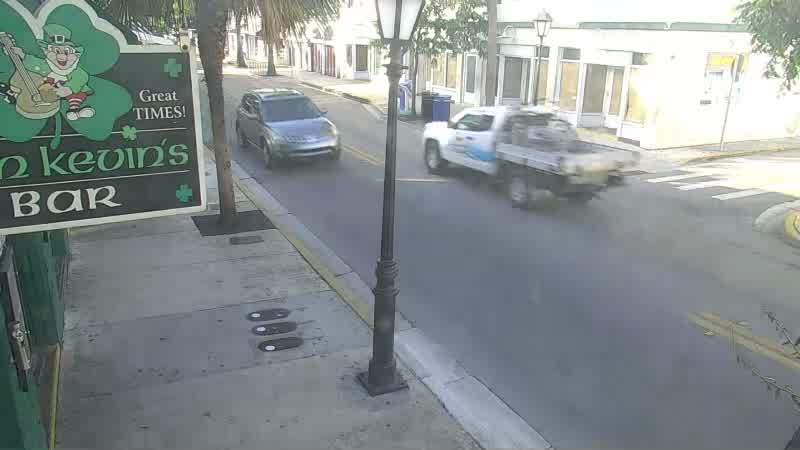

249


In [22]:
# from os import listdir
# import os, random, shutil
# from os.path import isfile, join
# from IPython.display import Image, display , clear_output
# import time



# # Part 3 - Making new predictions

# classifier = load_model("weights/siamese_4layers_v1.h5")

# i =1
# while i < 250:
# #     testnewset = (os.listdir("data/Florida/day1_0800/train/0800_none/")) 
#     testnewset = (os.listdir("data/Florida/day1_full/train/vehicles/")) 


#     testnewset_sorted = sorted(testnewset) 
# #     print(testnewset)
# #     print(testnewset_sorted) 

#     res = testnewset_sorted[i] 
#     print ("The frame number is : " +  str(res)) 
# #     test_img_path = f"data/Florida/day1_0800/train/0800_none/{res}"
#     test_img_path = f"data/Florida/day1_full/train/vehicles/{res}"
    


#     test_image = image.load_img(test_img_path, target_size = (400, 225))
#     test_image = image.img_to_array(test_image)
#     test_image = np.expand_dims(test_image, axis = 0)
#     result = classifier.predict(test_image) 
#     print(training_set.class_indices)  

#     print("Probability",result[0][0])

#     if result[0][0] > 0.5:
#         prediction = '0800_vehicles'
#     else:
#         prediction = '0800_none'

#     print("Prediction:",prediction)    
#     display(Image(test_img_path))
#     print(i)
#     time.sleep(0.42)

#     i +=1
#     clear_output(wait=True)